# Consensus clustering and consistency


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import igraph
import leidenalg
import numpy as np
import itertools
import pandas as pd
from nwtools import communities, consensus

In [2]:
g_test = igraph.Graph(directed=False)
node_names = [chr(c) for c in range(ord('A'), ord('H'))]
g_test.add_vertices(node_names)

g_test.add_edges([
    ('A', 'B'),
    ('A', 'C'),
    ('B', 'C'),
    ('C', 'D'),
    ('D', 'E'),
    ('D', 'F'),
    ('F', 'G'),
    ('D', 'G')
])

In [3]:
part1 = igraph.clustering.VertexClustering(g_test, [0,0,0,2,2,2,2])
part2 = igraph.clustering.VertexClustering(g_test, [0,0,1,1,1,2,2])
part3 = igraph.clustering.VertexClustering(g_test, [0,0,0,1,1,2,2])

n1 = 60
n2 = 30
n3 = 10

initial_partition = [part1]*n1 + [part2]*n2 + [part3]*n3

In [4]:
color_dict = {0: 'lightblue', 1: 'green', 2: 'red'}
#layout = g_test.layout('kk')
layout = [(0, 1),
          (2, 0),
          (1, 2),
          (0, 3),
          (1, 3),
          (0, 4),
          (2, 4)
         ]
layout = [(y,x) for x,y in layout]

60 partitions


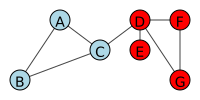

In [5]:
print('{} partitions'.format(n1))
igraph.plot(g_test, layout=layout, 
            vertex_color = [color_dict[c] for c in part1.membership],
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

30 partitions


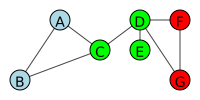

In [6]:
print('{} partitions'.format(n2))
igraph.plot(g_test, layout=layout, 
            vertex_color = [color_dict[c] for c in part2.membership],
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

10 partitions


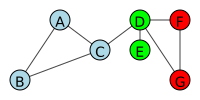

In [7]:
print('{} partitions'.format(n3))
igraph.plot(g_test, layout=layout, 
            vertex_color = [color_dict[c] for c in part3.membership],
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

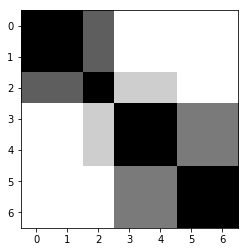

In [8]:
consensus_mat = consensus.get_consensus_matrix(initial_partition, g_test.vcount())
plt.imshow(consensus_mat, cmap='Greys')
#plt.xticks.l(node_names)

In [9]:
edge_indices = [e.tuple for e in g_test.es]
edge_indices

[(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (3, 5), (5, 6), (3, 6)]

In [10]:
ix, jx = zip(*edge_indices)
consensus_df = pd.DataFrame({'Source': [node_names[i] for i in ix],
                             'Target': [node_names[j] for j in jx],
                            'consensus': consensus_mat[ix, jx]})

In [11]:
consensus_df['consistency'] = 2*np.abs(consensus_df.consensus-0.5)

In [12]:
consensus_df

,Source,Target,consensus,consistency
0,A,B,1.0,1.0
1,A,C,0.7,0.4
2,B,C,0.7,0.4
3,C,D,0.3,0.4
4,D,E,1.0,1.0
5,D,F,0.6,0.2
6,F,G,1.0,1.0
7,D,G,0.6,0.2


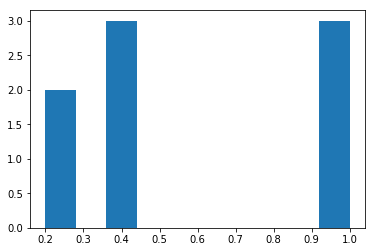

In [13]:
plt.hist(consensus_df.consistency)
plt.show()

In [14]:
def get_node_stability(graph, edges_df, thres_list=None):
    suffix = ''
    names = graph.vs.get_attribute_values('name')
    nodes_df = pd.DataFrame(index=names)
    nodes_df['degree'+suffix] = pd.Series(graph.degree(), index=names)
    #nodes_df['weighted_degree'+suffix] = pd.Series(graph.strength(weights='weight'), index=names)
    nodes_df['eigenvector_centrality'+suffix] = pd.Series(
        graph.eigenvector_centrality(directed=False), index=names)
    nodes_df['betweenness'+suffix] = pd.Series(graph.betweenness(directed=False), index=names)
    edges_unstacked = edges_df.consistency.unstack()
    
    stabilities_unstacked = edges_unstacked.add(edges_unstacked.transpose(), fill_value=0)

    nodes_df['consistency_mean'] = stabilities_unstacked.mean(axis=0)
    nodes_df['consistency_min'] = stabilities_unstacked.min(axis=0)
    nodes_df['consistency_max'] = stabilities_unstacked.max(axis=0)
    nodes_df['consistency_std'] = stabilities_unstacked.apply(np.std, axis=0)
    nodes_df['consistency_mean_min_std'] = nodes_df['consistency_mean'] - nodes_df['consistency_std']
    if thres_list is None:
        thres_list = [0.8, 0.9, 1.0]
    for thres in thres_list:
        perc_consistent_neigbors =  (stabilities_unstacked>=thres).sum(axis=0) / (~stabilities_unstacked.isna()).sum(axis=0)
        nodes_df['consistency_neighbors_{:.1f}'.format(thres)] =perc_consistent_neigbors
        
    return nodes_df

In [15]:
node_consistency = get_node_stability(g_test, consensus_df.set_index(['Source', 'Target']),
                                     thres_list=[0.5, 0.65, 1])

In [16]:
node_consistency

,degree,eigenvector_centrality,betweenness,consistency_mean,consistency_min,consistency_max,consistency_std,consistency_mean_min_std,consistency_neighbors_0.5,consistency_neighbors_0.7,consistency_neighbors_1.0
A,2,0.537997,0.0,0.70,0.4,1.0,3.000000e-01,0.400000,0.50,0.50,0.50
B,2,0.537997,0.0,0.70,0.4,1.0,3.000000e-01,0.400000,0.50,0.50,0.50
C,3,0.821524,8.0,0.40,0.4,0.4,5.551115e-17,0.400000,0.00,0.00,0.00
D,4,1.000000,11.0,0.45,0.2,1.0,3.278719e-01,0.122128,0.25,0.25,0.25
E,1,0.395726,0.0,1.00,1.0,1.0,0.000000e+00,1.000000,1.00,1.00,1.00
F,2,0.654877,0.0,0.60,0.2,1.0,4.000000e-01,0.200000,0.50,0.50,0.50
G,2,0.654877,0.0,0.60,0.2,1.0,4.000000e-01,0.200000,0.50,0.50,0.50


(-0.1, 1.1)

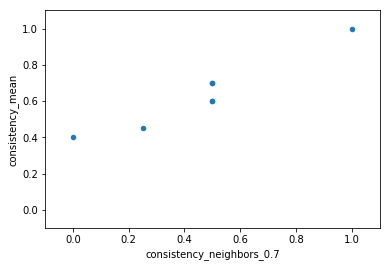

In [17]:
node_consistency.plot('consistency_neighbors_0.7', 'consistency_mean', kind='scatter')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

(-0.1, 1.1)

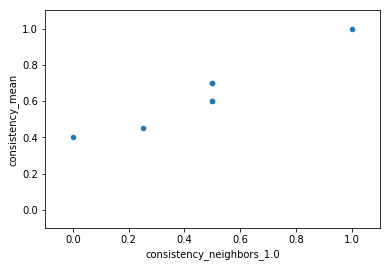

In [18]:
node_consistency.plot('consistency_neighbors_1.0', 'consistency_mean', kind='scatter')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

In [19]:
node_consistency['consistency_neighbors_1.0'].sort_values()

C    0.00
D    0.25
A    0.50
B    0.50
F    0.50
G    0.50
E    1.00
Name: consistency_neighbors_1.0, dtype: float64

In [20]:
node_consistency['consistency_neighbors_0.5'].sort_values()

C    0.00
D    0.25
A    0.50
B    0.50
F    0.50
G    0.50
E    1.00
Name: consistency_neighbors_0.5, dtype: float64

In [21]:
import matplotlib 
cm = matplotlib.cm.get_cmap('Greens')

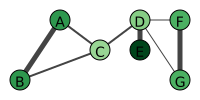

In [22]:
attr = 'consistency_mean' #'consistency_neighbors_0.7'
igraph.plot(g_test, layout=layout, 
            vertex_color = [cm(c) for c in node_consistency[attr]],
            edge_width = 5*consensus_df.consistency,
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

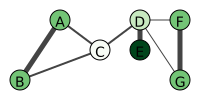

In [23]:
attr = 'consistency_neighbors_1.0'
igraph.plot(g_test, layout=layout, 
            vertex_color = [cm(c) for c in node_consistency[attr]],
             edge_width = 5*consensus_df.consistency,
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

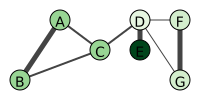

In [24]:
attr = 'consistency_mean_min_std' #'consistency_neighbors_0.7'
igraph.plot(g_test, layout=layout, 
            vertex_color = [cm(c) for c in node_consistency[attr]],
             edge_width = 5*consensus_df.consistency,
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))